In [1]:
import numpy as np
from glob import glob
import os

from tqdm import notebook
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout 
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D,concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

2021-08-24 07:49:29.613312: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
data_path = "/home/samsmu/Data/Lung/CT"
working_path = data_path + "/Temp/"

# Set some parameters
im_width = 512
im_height = 512

In [3]:
X_train = np.load(working_path+"trainImages.npy").astype(np.float32)
y_train = np.load(working_path+"trainMasks.npy").astype(np.float32)
X_train =  np.moveaxis(X_train, 1,3)
y_train =  np.moveaxis(y_train, 1,3)
X_train = X_train/X_train.max()
y_train = y_train/y_train.max()

X_valid = np.load(working_path+"testImages.npy").astype(np.float32)
y_valid = np.load(working_path+"testMasks.npy").astype(np.float32)
X_valid = np.moveaxis(X_valid, 1,3)
y_valid =  np.moveaxis(y_valid, 1,3)
X_valid = X_valid/X_valid.max()
y_valid = y_valid/y_valid.max()    

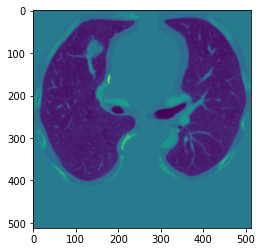

In [12]:
plt.imshow(X_valid[6])

Text(0.5, 1.0, 'Nodule')

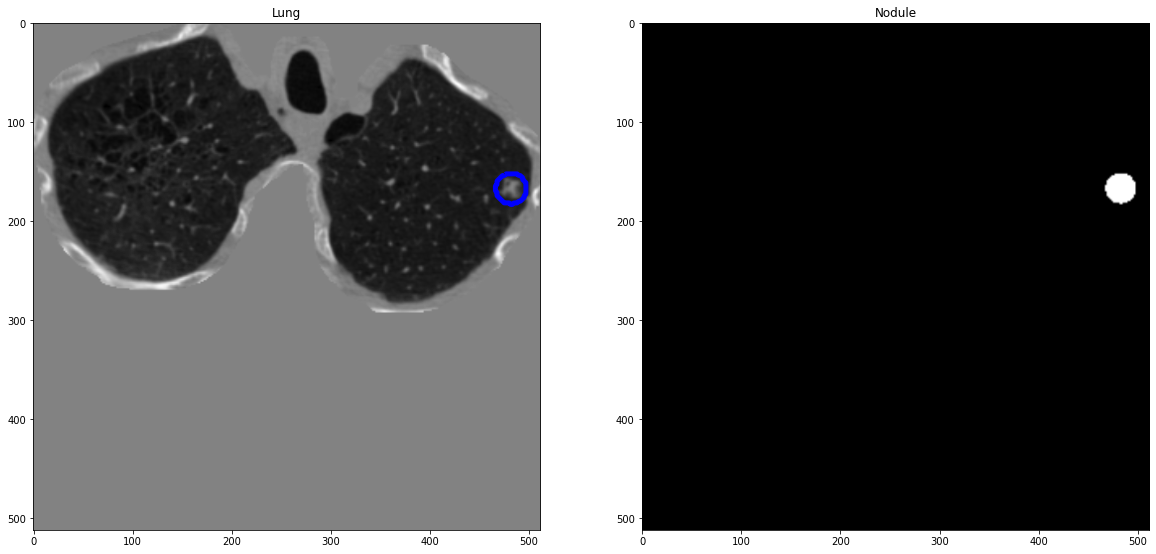

In [4]:
# Visualize any randome image along with the mask
ix = np.random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # nodule indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix,..., 0], cmap = 'gray')
if has_mask: # if nodule
    # draw a boundary(contour) in the original image separating nodule and non-nodule areas
    ax1.contour(y_train[ix].squeeze(), colors = 'b', linewidths = 5, levels = [0.5])
ax1.set_title('Lung')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Nodule')

### UNet

In [5]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = kernel_size, padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = kernel_size, padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [6]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

In [ ]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model_file = 'model-nodules.h5'

In [9]:
model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=dice_coef)
model_file = 'model-nodules-dice.h5'

In [10]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(model_file, verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=4, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

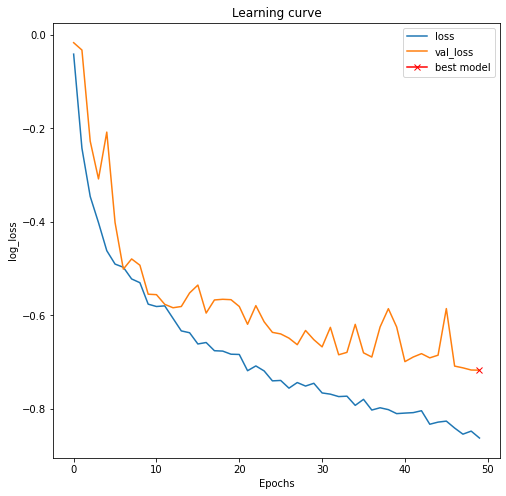

In [12]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [10]:
### Inference

In [13]:
# load the best model
model.load_weights('model-nodules.h5')

In [14]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

2021-08-17 11:49:39.010430: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 451936256 exceeds 10% of free system memory.


14/14 [==============================] - 47s 2s/step - loss: -0.7261 - dice_coef: 0.7308


[-0.7261254191398621, 0.7307995557785034]

In [15]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

14/14 [==============================] - 2s 129ms/step


In [16]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [17]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = np.random.randint(0, len(X))
    
    print(ix)
    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[0].set_title('Lung')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Nodule')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[2].set_title('Nodule Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[3].set_title('Nodule Predicted binary');

58


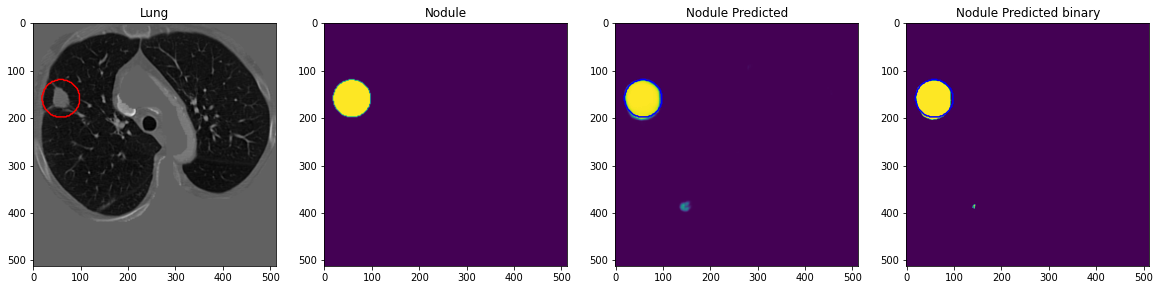

In [31]:
# Check if training data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

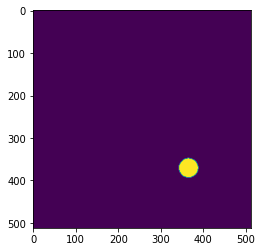

In [100]:
ix = 140
plt.imshow(y_valid[ix].squeeze())

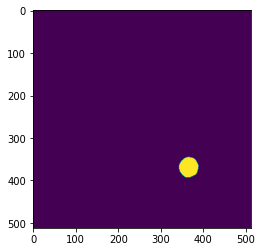

In [101]:
plt.imshow(preds_val_t[ix].squeeze())

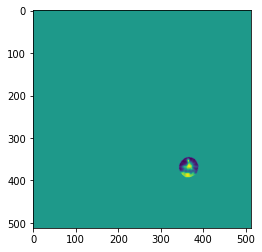

In [102]:
mask = preds_val_t[ix].squeeze()
mask
img = X_valid[ix].squeeze()
slice_npy = mask * img
plt.imshow(slice_npy)